In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [231]:
prefix = "../wg-rb-perf2"

In [232]:
def update_fontsize(size=12):
    mp.rcParams.update({'font.size': size})

In [349]:
def import_data(path, n_clients=100):
    SOCK_NAMES = ['throughput', 'latency']
    CPU_NAMES = ['timestamp', 'wait', 'used', 'core', 'comm']
    SPIN_NAMES=['decrypt_worker', 'decrypt_packet', 'spinlock']
    
    # Import throughput and latency data
    df = pd.read_csv(f"{path}/sock-{n_clients}.csv", names=SOCK_NAMES)
   
    # Import CPU data
    cpu_df = pd.read_csv(f"{path}/cpu-{n_clients}.csv", names=CPU_NAMES)
    num_pids = len(cpu_df.comm.unique())
    tmp = cpu_df.groupby(['timestamp', 'core']).sum(numeric_only=True).reset_index()
    tmp = tmp.groupby('core').median(numeric_only=True).mean()
    df['cpu'] = tmp['used']
    df['num_pids'] = num_pids

    # Import lock data
    wg_df = pd.read_csv(f"{path}/wg-{n_clients}.csv", names=SPIN_NAMES)

    # Import micro data
    micro_df = pd.read_csv(f"{path}/micro-{n_clients}.csv")
    
    df = pd.concat([df, wg_df, micro_df], axis=1)
    return df

In [350]:
benchmarks = os.listdir(prefix)
variants = {'-'.join(name.split('-')[2:]).upper().replace('-POOL', ''): name for name in benchmarks}

variants

{'VANILLA': 'benchmark-wireguard-vanilla',
 'MULTI-QUEUE': 'benchmark-wireguard-multi-queue-pool',
 'NO-QUEUE': 'benchmark-wireguard-no-queue',
 'MULTI-QUEUE-STEERING': 'benchmark-wireguard-multi-queue-pool-steering',
 'BATCH': 'benchmark-wireguard-batch'}

In [351]:
dfs = {}

# Import Vanilla

In [352]:
path = f"{prefix}/{variants[bench]}/summary"
df = pd.read_csv(f"{path}/cpu-100.csv", names=CPU_NAMES)

In [353]:
bench = 'VANILLA'
path = f"{prefix}/{variants[bench]}/summary"
df = import_data(path)
df['variant'] = 'SSRB'
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']

dfs[bench] = df
df_vanilla = df

# Import No queue

In [354]:
bench = 'NO-QUEUE'
path = f"{prefix}/{variants[bench]}/summary"
df = import_data(path)
df['variant'] = "NRB"
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
dfs[bench] = df
df_nq = df
df_nq['spinlock'] = 0.1

# Import Batch

In [355]:
bench = 'BATCH'
path = f"{prefix}/{variants[bench]}/summary"

batches = sorted([int(i.split('-')[-1]) for i in os.listdir(path)])
df = []
for batch in batches:
    path_batch = f"{path}/batch-{batch}/ring-1"
    tmp = import_data(path_batch)
    tmp['batch'] = batch
    df.append(tmp)
df = pd.concat(df, axis=0)
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
df['variant'] = "SSRB-BC"
dfs[bench] = df
df_batch = df

# Import MRB

In [356]:
bench = 'MULTI-QUEUE'
path = f"{prefix}/{variants[bench]}/summary/batch-1"

rings = sorted([int(i.split('-')[-1]) for i in os.listdir(path)])

df = []
for ring in rings:
    path_ring = f"{path}/ring-{ring}"
    tmp = import_data(path_ring)
    tmp['ring'] = ring
    df.append(tmp)
df = pd.concat(df, axis=0)
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
df['variant'] = 'MRB'
dfs[bench] = df
df_mrb = df

# MRB-Steering

In [357]:
bench = 'MULTI-QUEUE-STEERING'
path = f"{prefix}/{variants[bench]}/summary/batch-1"

rings = sorted([int(i.split('-')[-1]) for i in os.listdir(path)])

df = []
for ring in rings:
    path_ring = f"{path}/ring-{ring}"
    tmp = import_data(path_ring)
    tmp['ring'] = ring
    df.append(tmp)
df = pd.concat(df, axis=0)
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
df['variant'] = 'MRB'
dfs[bench] = df
df_mrb_str = df

In [358]:
df_batch

,throughput,latency,cpu,num_pids,decrypt_worker,decrypt_packet,spinlock,cache_miss,cache_ops,context_switch,...,end,batch,duration,cache_miss_ratio,l1_ratio,llc_ratio,migrations/s,cs/s,faults/s,variant
0,19.524382,73.0586,99.138889,321,75.77,128.26,0.72,32026,44722,84419,...,3055.548901,2,5.010763,0.716113,0.998883,0.839946,882.500330,16847.533998,11.175943,SSRB-BC
0,18.440410,143.5420,98.222222,317,77.43,131.58,0.71,31847,44680,86836,...,3155.702756,4,5.007869,0.712780,0.998862,0.851656,837.082599,17339.910449,9.385230,SSRB-BC
0,17.704984,121.5920,88.833333,262,77.46,132.63,0.86,31907,44652,86820,...,3255.478200,8,5.008617,0.714570,0.998346,0.861499,655.071051,17334.126367,10.382107,SSRB-BC
0,19.842967,113.1570,99.833333,281,77.61,131.41,0.73,31613,44700,86209,...,3356.450404,16,5.009035,0.707226,1.000134,0.833464,877.214873,17210.700265,11.179798,SSRB-BC


In [359]:
def plot_(df, x, y, xlabel, ylabel, fontsize=16, ylim=None, normal_value=None, text_offset=0, text_spacing=1, savefig=None):
    with plt.style.context(['science', 'ieee']):
        update_fontsize(fontsize)
        ax = df.plot.bar(x=x, y=y, ylim=ylim,
                         ylabel=ylabel,legend=None,
                        xlabel=xlabel, grid=True,
                         )
        if normal_value is not None:
            ax.axhline(y=normal_value, color='red', linestyle='--', label='vanilla')
            ax.annotate(
                f'VANILLA', 
                xy=(2, normal_value), 
                xytext=(text_offset, normal_value+text_spacing), color='red'
            )
        plt.xticks(rotation=0)
        if savefig is not None:
            plt.savefig(savefig, dpi=400)
        else:
            plt.show()

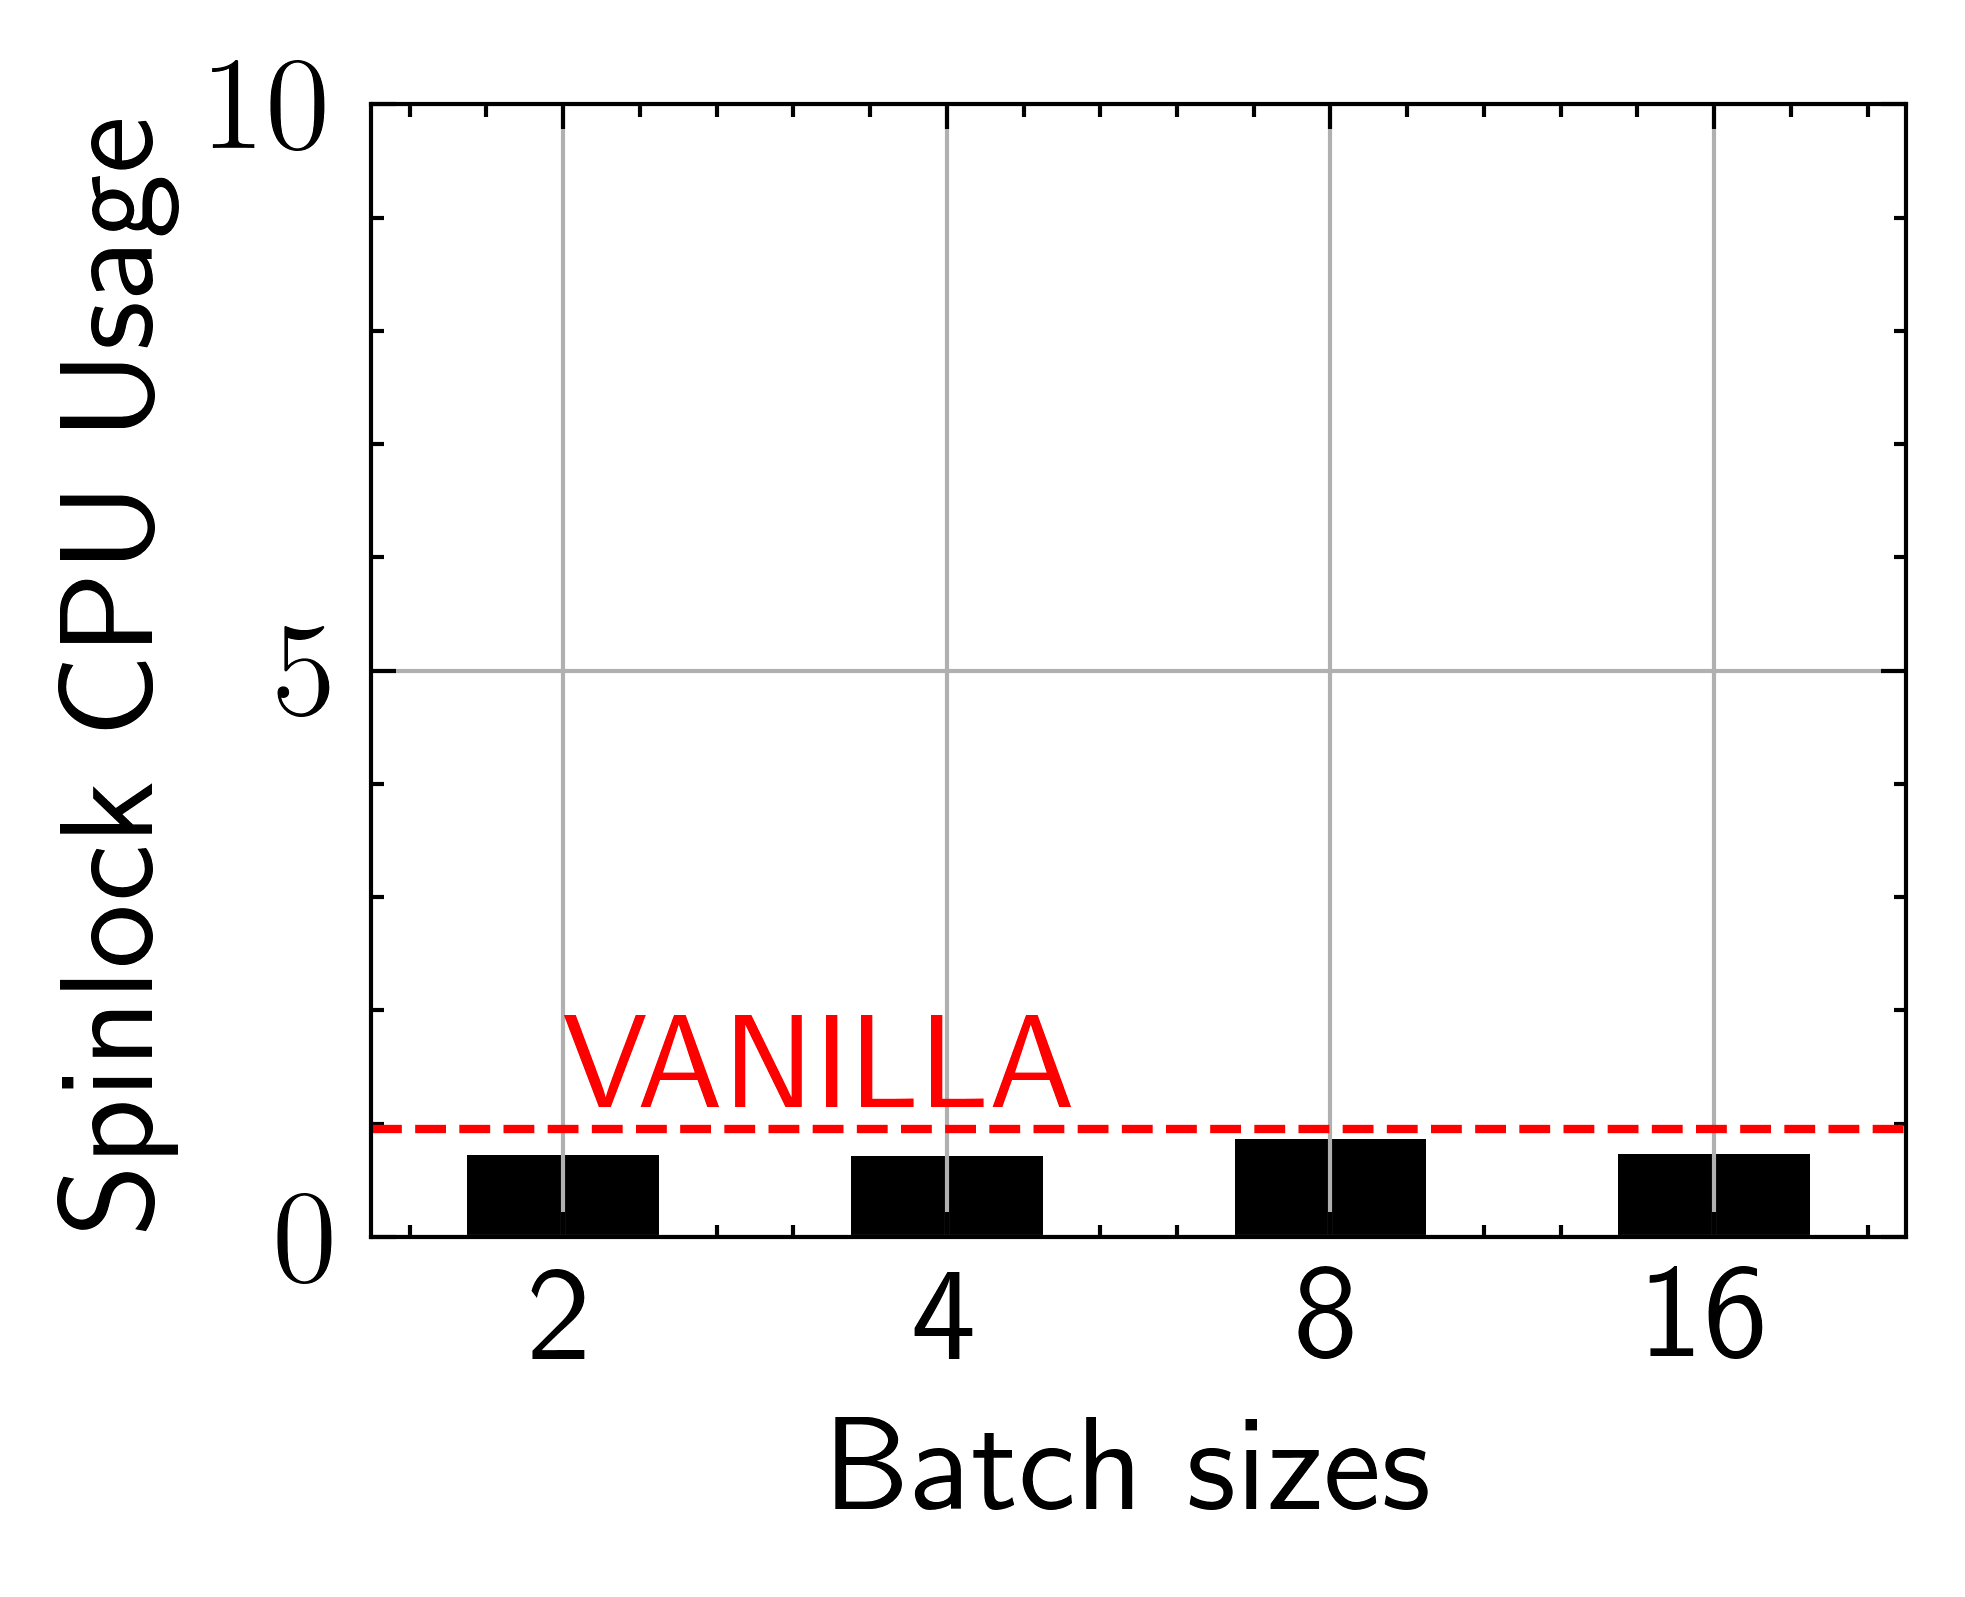

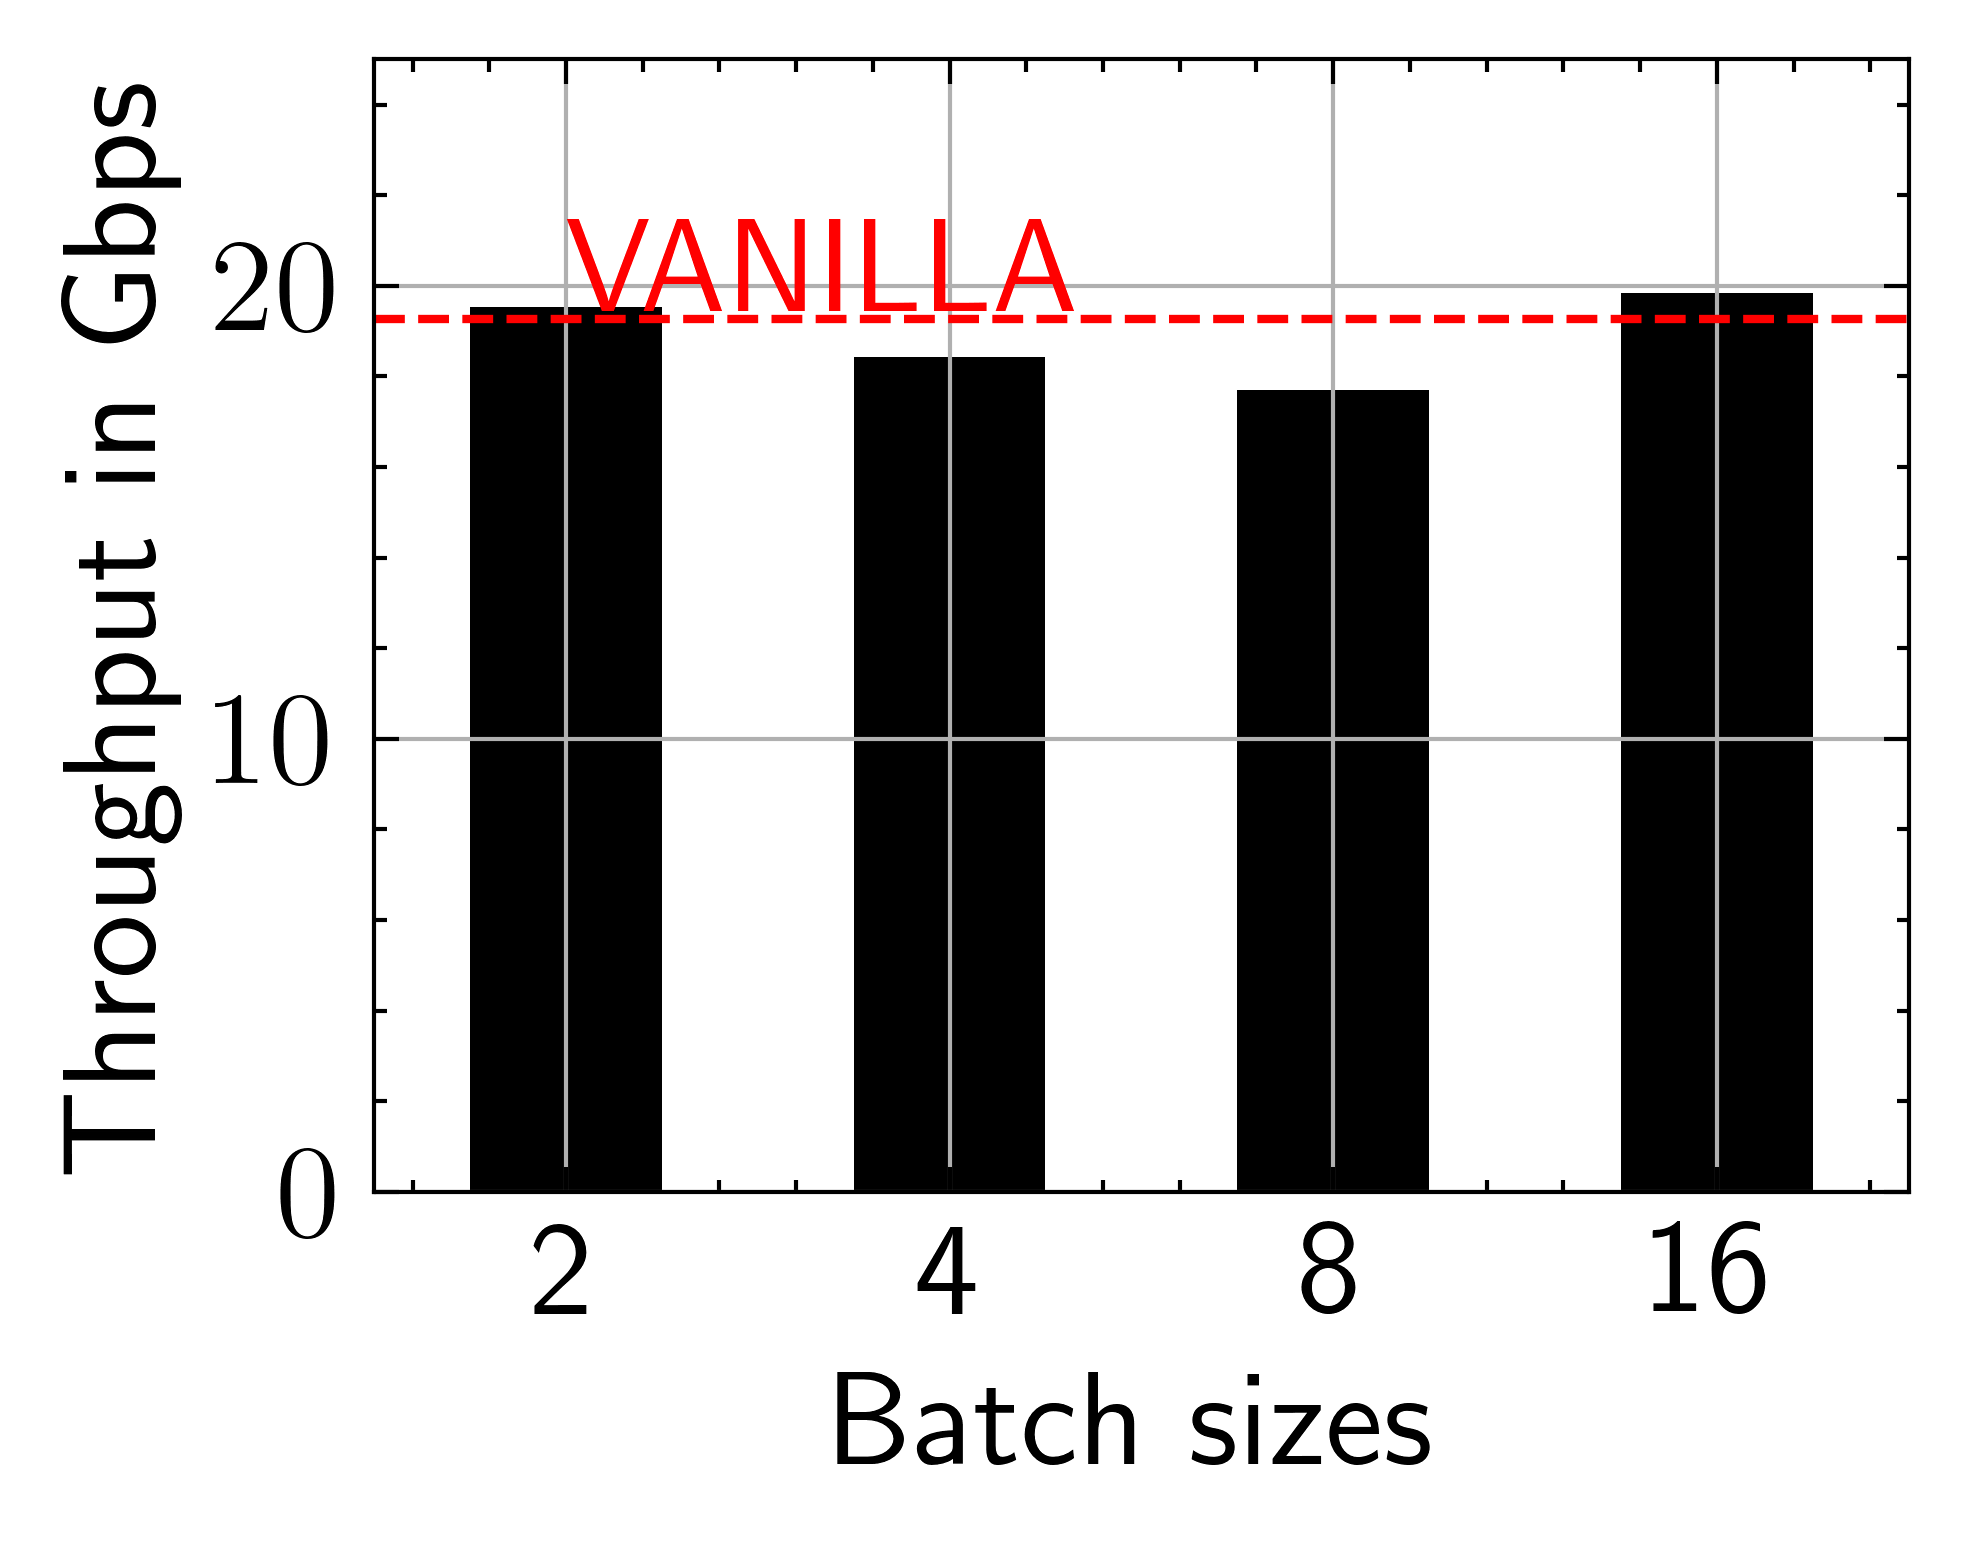

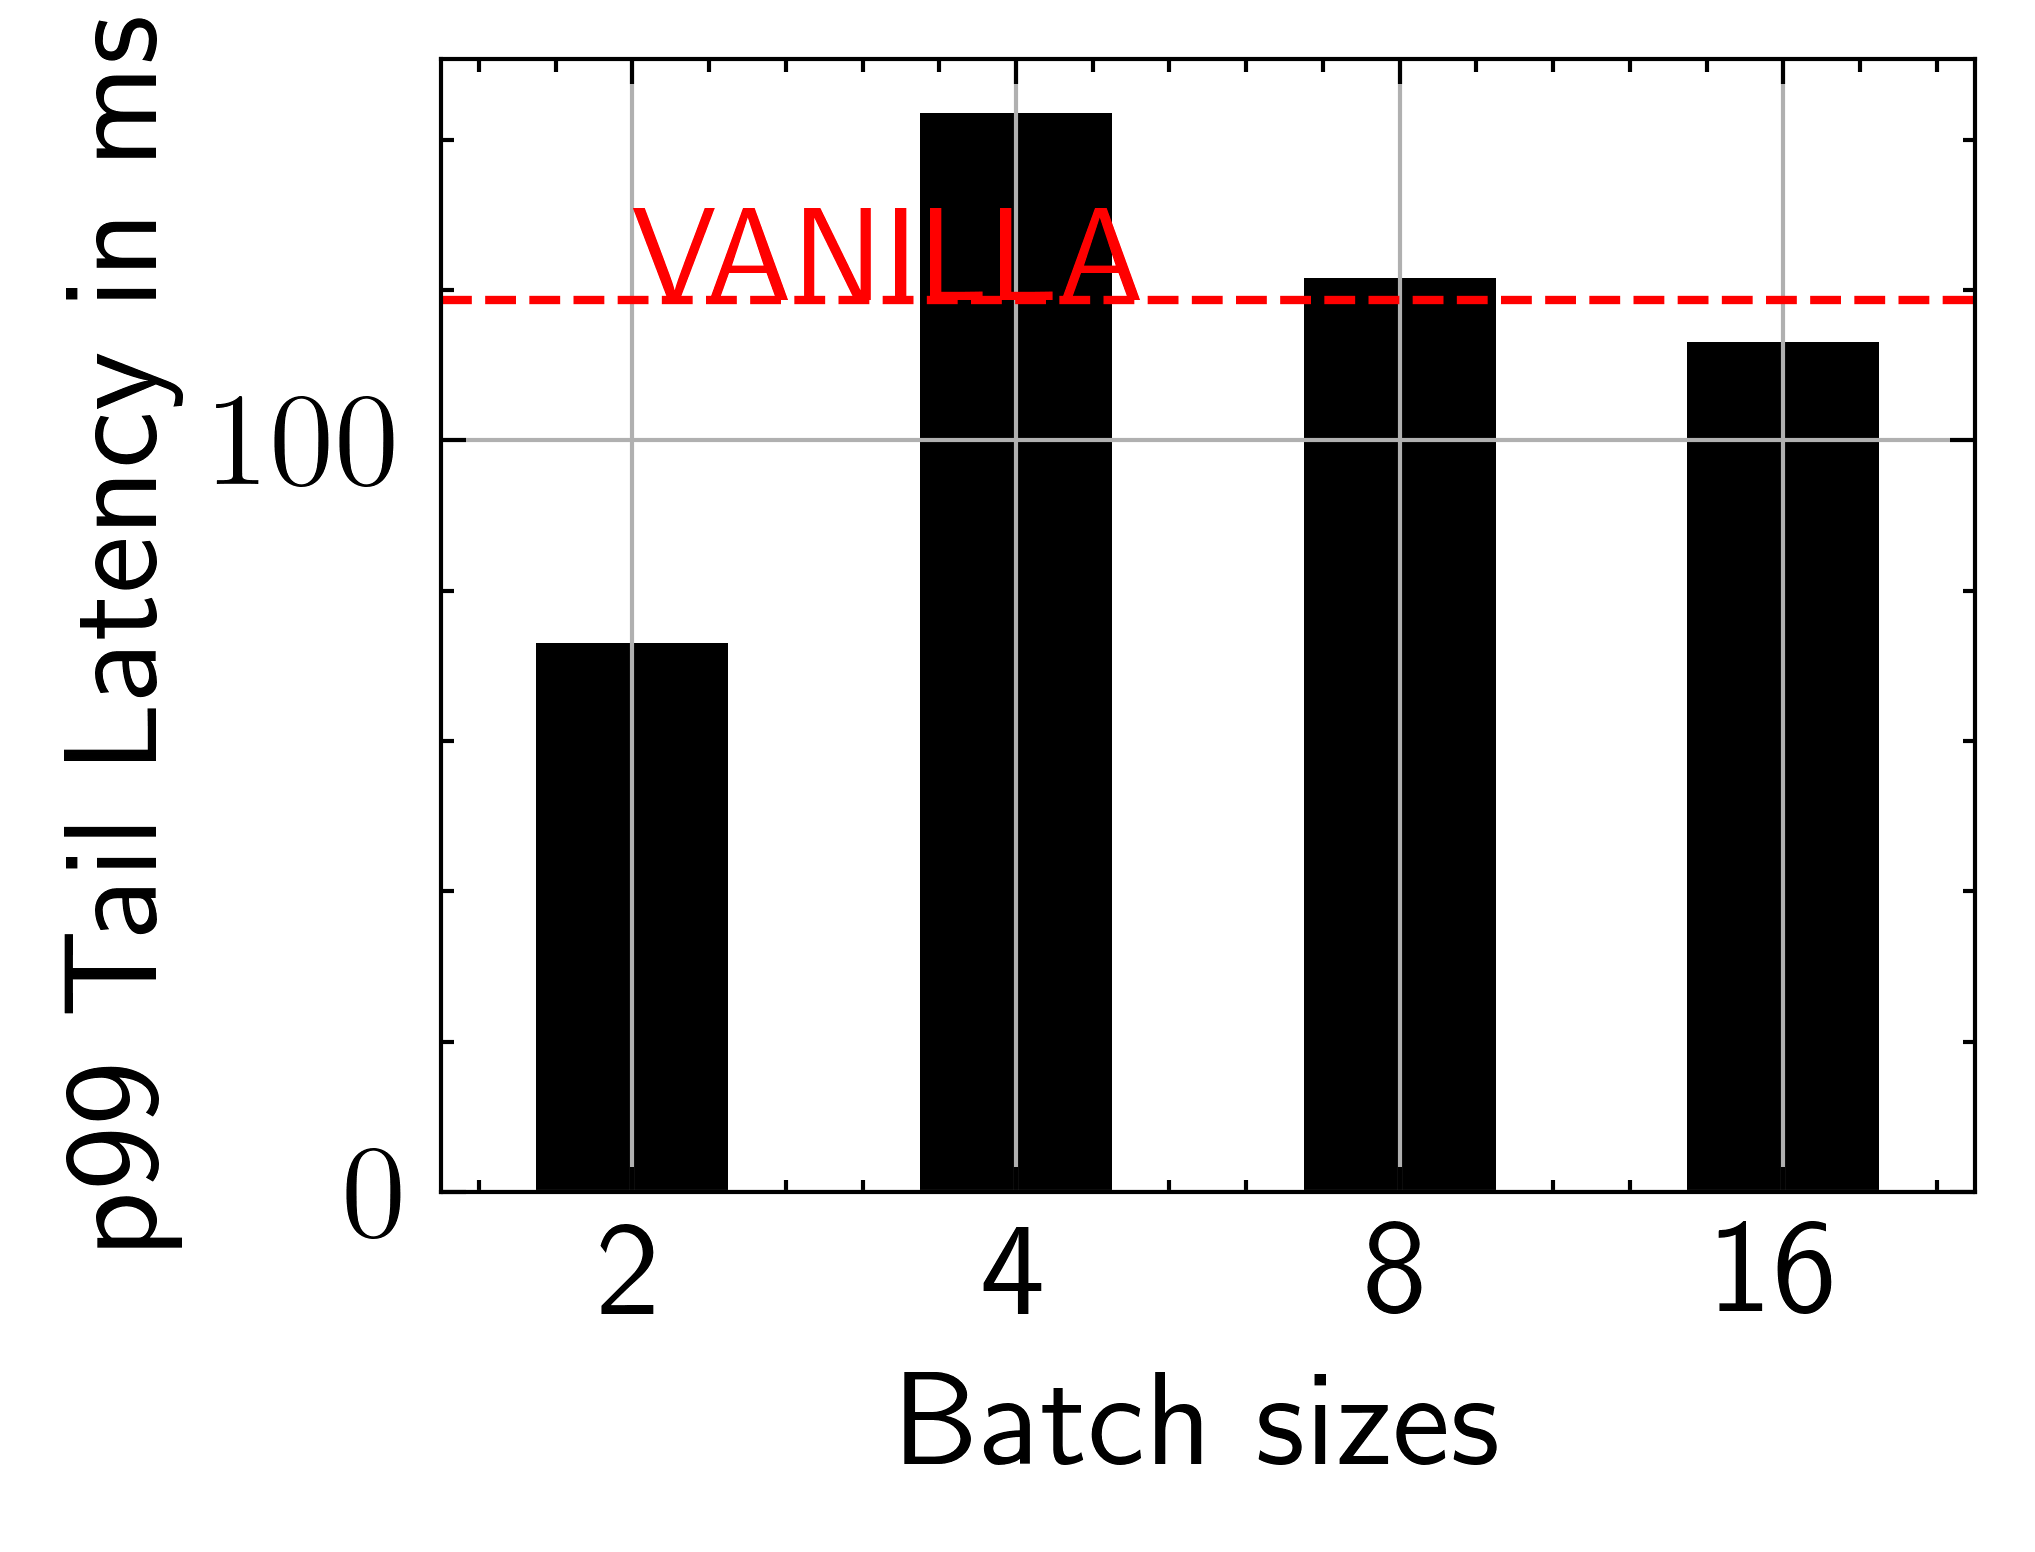

In [360]:
normal_value = df_vanilla.iloc[0].spinlock
text_offset = 0
text_spacing = .2
x = 'batch'
y = 'spinlock'
xlabel='Batch sizes'
ylabel='Spinlock CPU Usage'
ylim = [0, 10]


plot_(df_batch, x, y, xlabel, ylabel,
     ylim=ylim,
     normal_value=normal_value,
     text_spacing=text_spacing,
     savefig='ssrb-bc-spinlock.pdf'
)

plot_(df_batch, x, 'throughput', xlabel, "Throughput in Gbps",
     ylim=[0, 25],
     normal_value=df_vanilla.iloc[0].throughput,
     text_spacing=text_spacing,
     savefig='ssrb-bc-tp.pdf'
)

plot_(df_batch, x, 'latency', xlabel, "p99 Tail Latency in ms",
     ylim=None,
     normal_value=df_vanilla.iloc[0].latency,
     text_spacing=text_spacing,
     savefig='ssrb-bc-lat.pdf'
)

In [361]:
df_mrb

,throughput,latency,cpu,num_pids,decrypt_worker,decrypt_packet,spinlock,cache_miss,cache_ops,context_switch,...,end,ring,duration,cache_miss_ratio,l1_ratio,llc_ratio,migrations/s,cs/s,faults/s,variant
0,19.437549,63.7045,99.944444,240,77.57,131.73,0.70,32310,44810,86088,...,4047.196735,2,5.009783,0.721044,0.998128,0.851700,743.345570,17183.977829,9.182034,MRB
0,18.694258,110.0940,99.111111,269,70.36,114.70,0.96,30530,44182,83968,...,4146.553100,4,5.008814,0.691005,0.998490,0.804806,1957.948528,16764.048336,9.782755,MRB
0,19.733714,138.9730,99.777500,285,72.63,121.77,0.64,31465,44646,81607,...,4246.030299,8,5.011695,0.704766,0.999843,0.811311,1104.815836,16283.313330,9.378065,MRB
0,19.783213,73.2932,99.944444,273,70.53,117.41,0.77,30803,44511,80378,...,4346.153802,18,5.009620,0.692031,1.000697,0.799634,1507.499571,16044.729940,11.178493,MRB


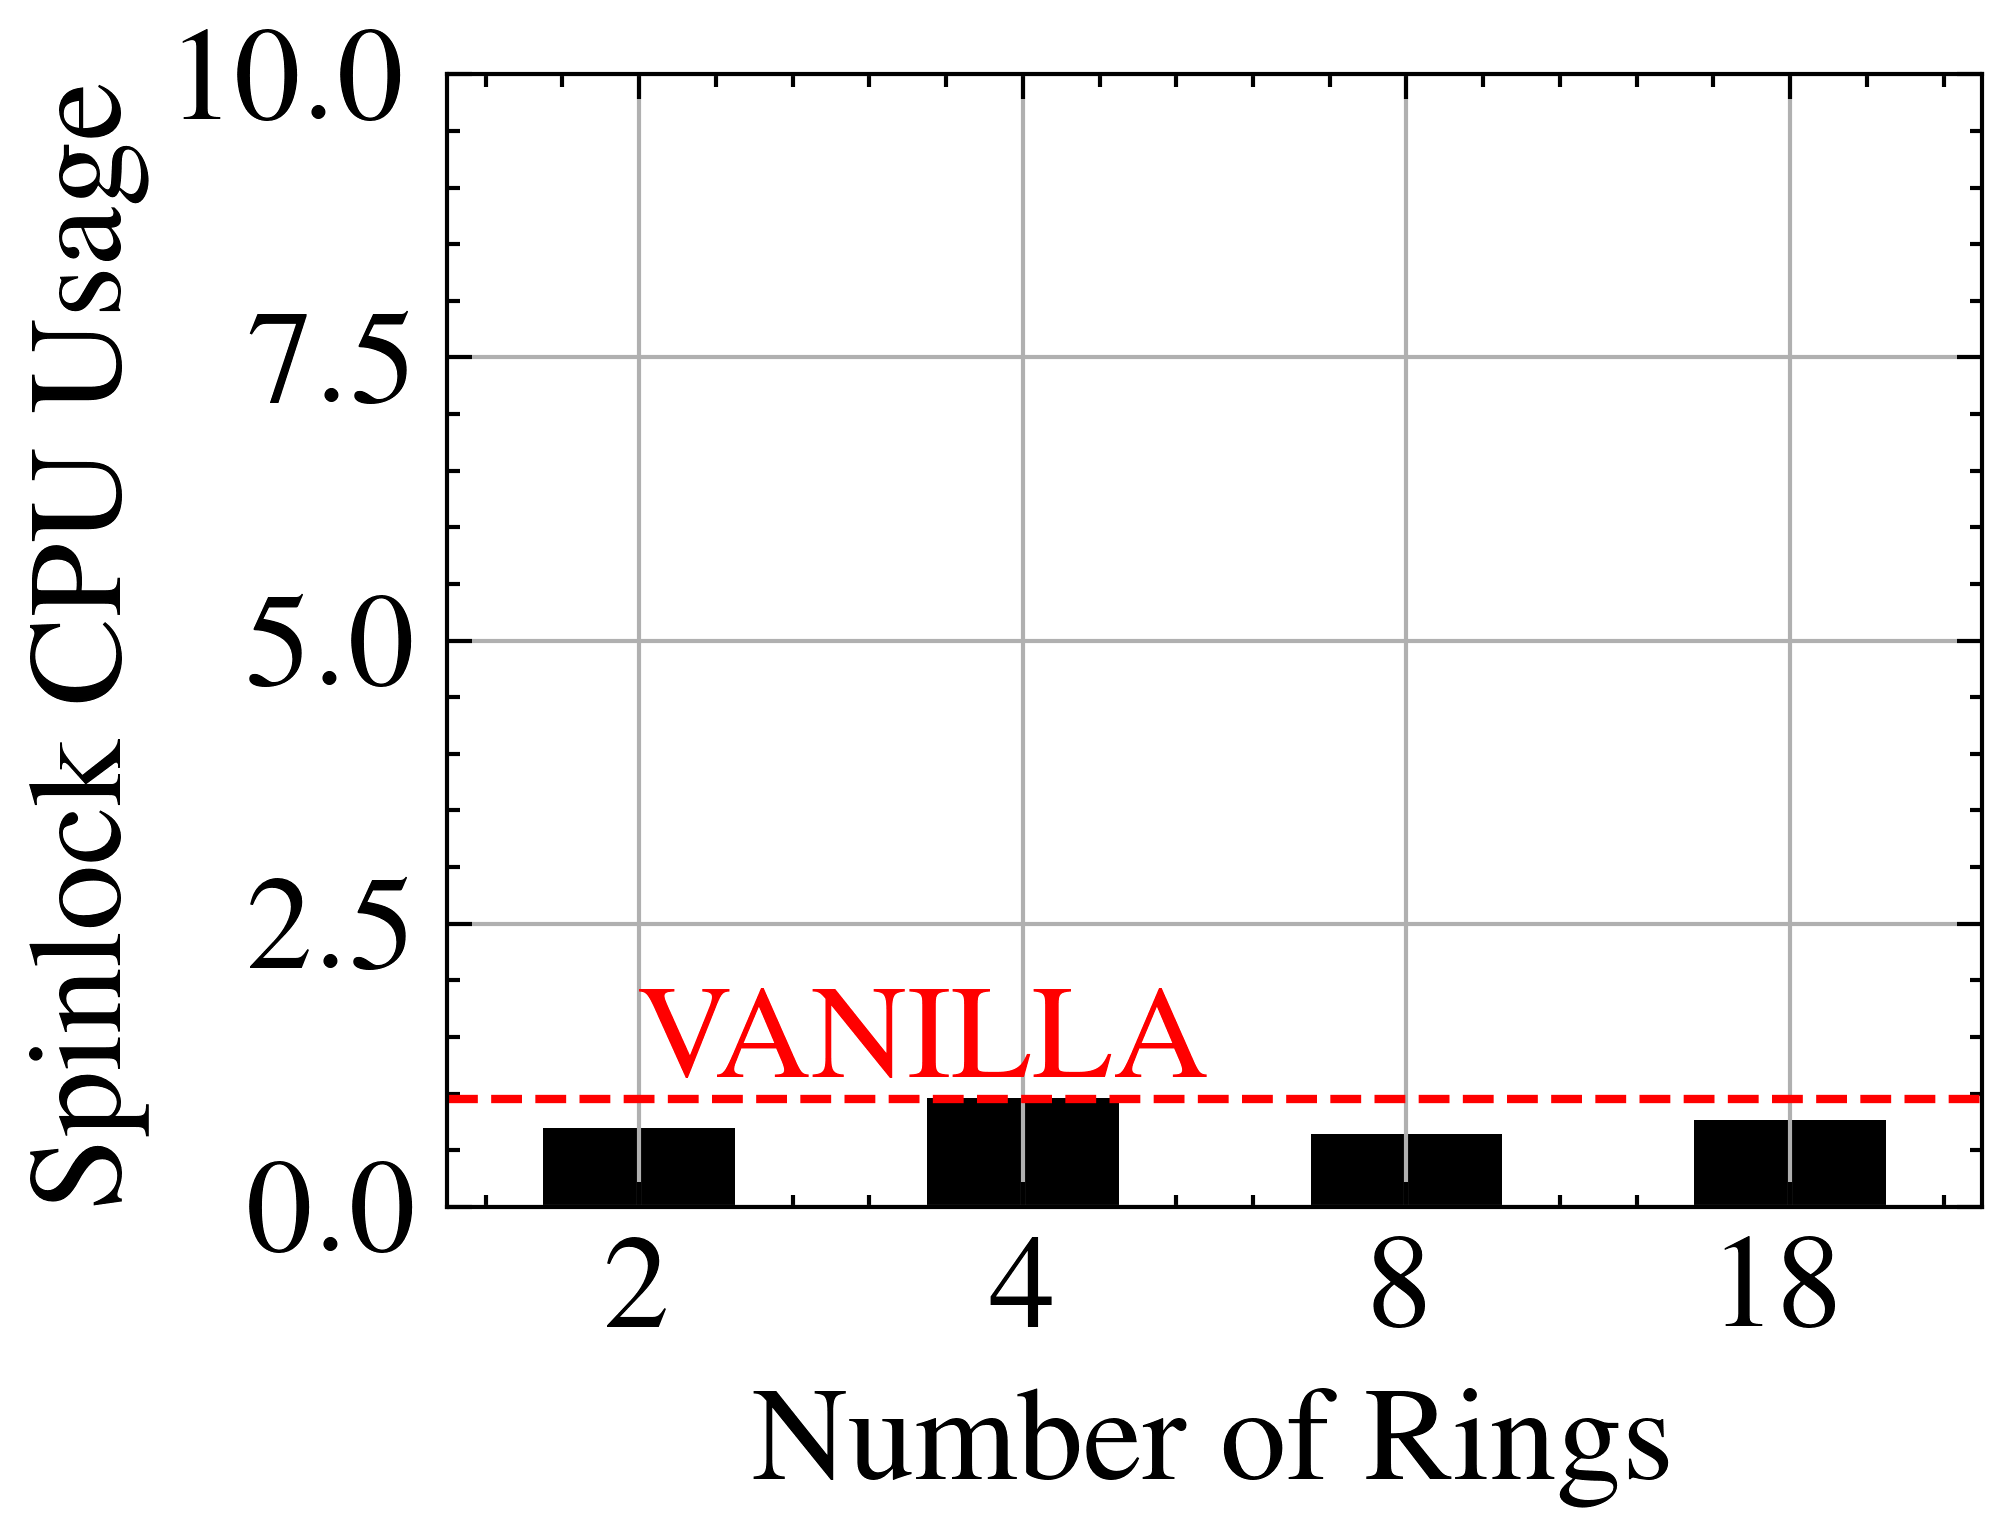

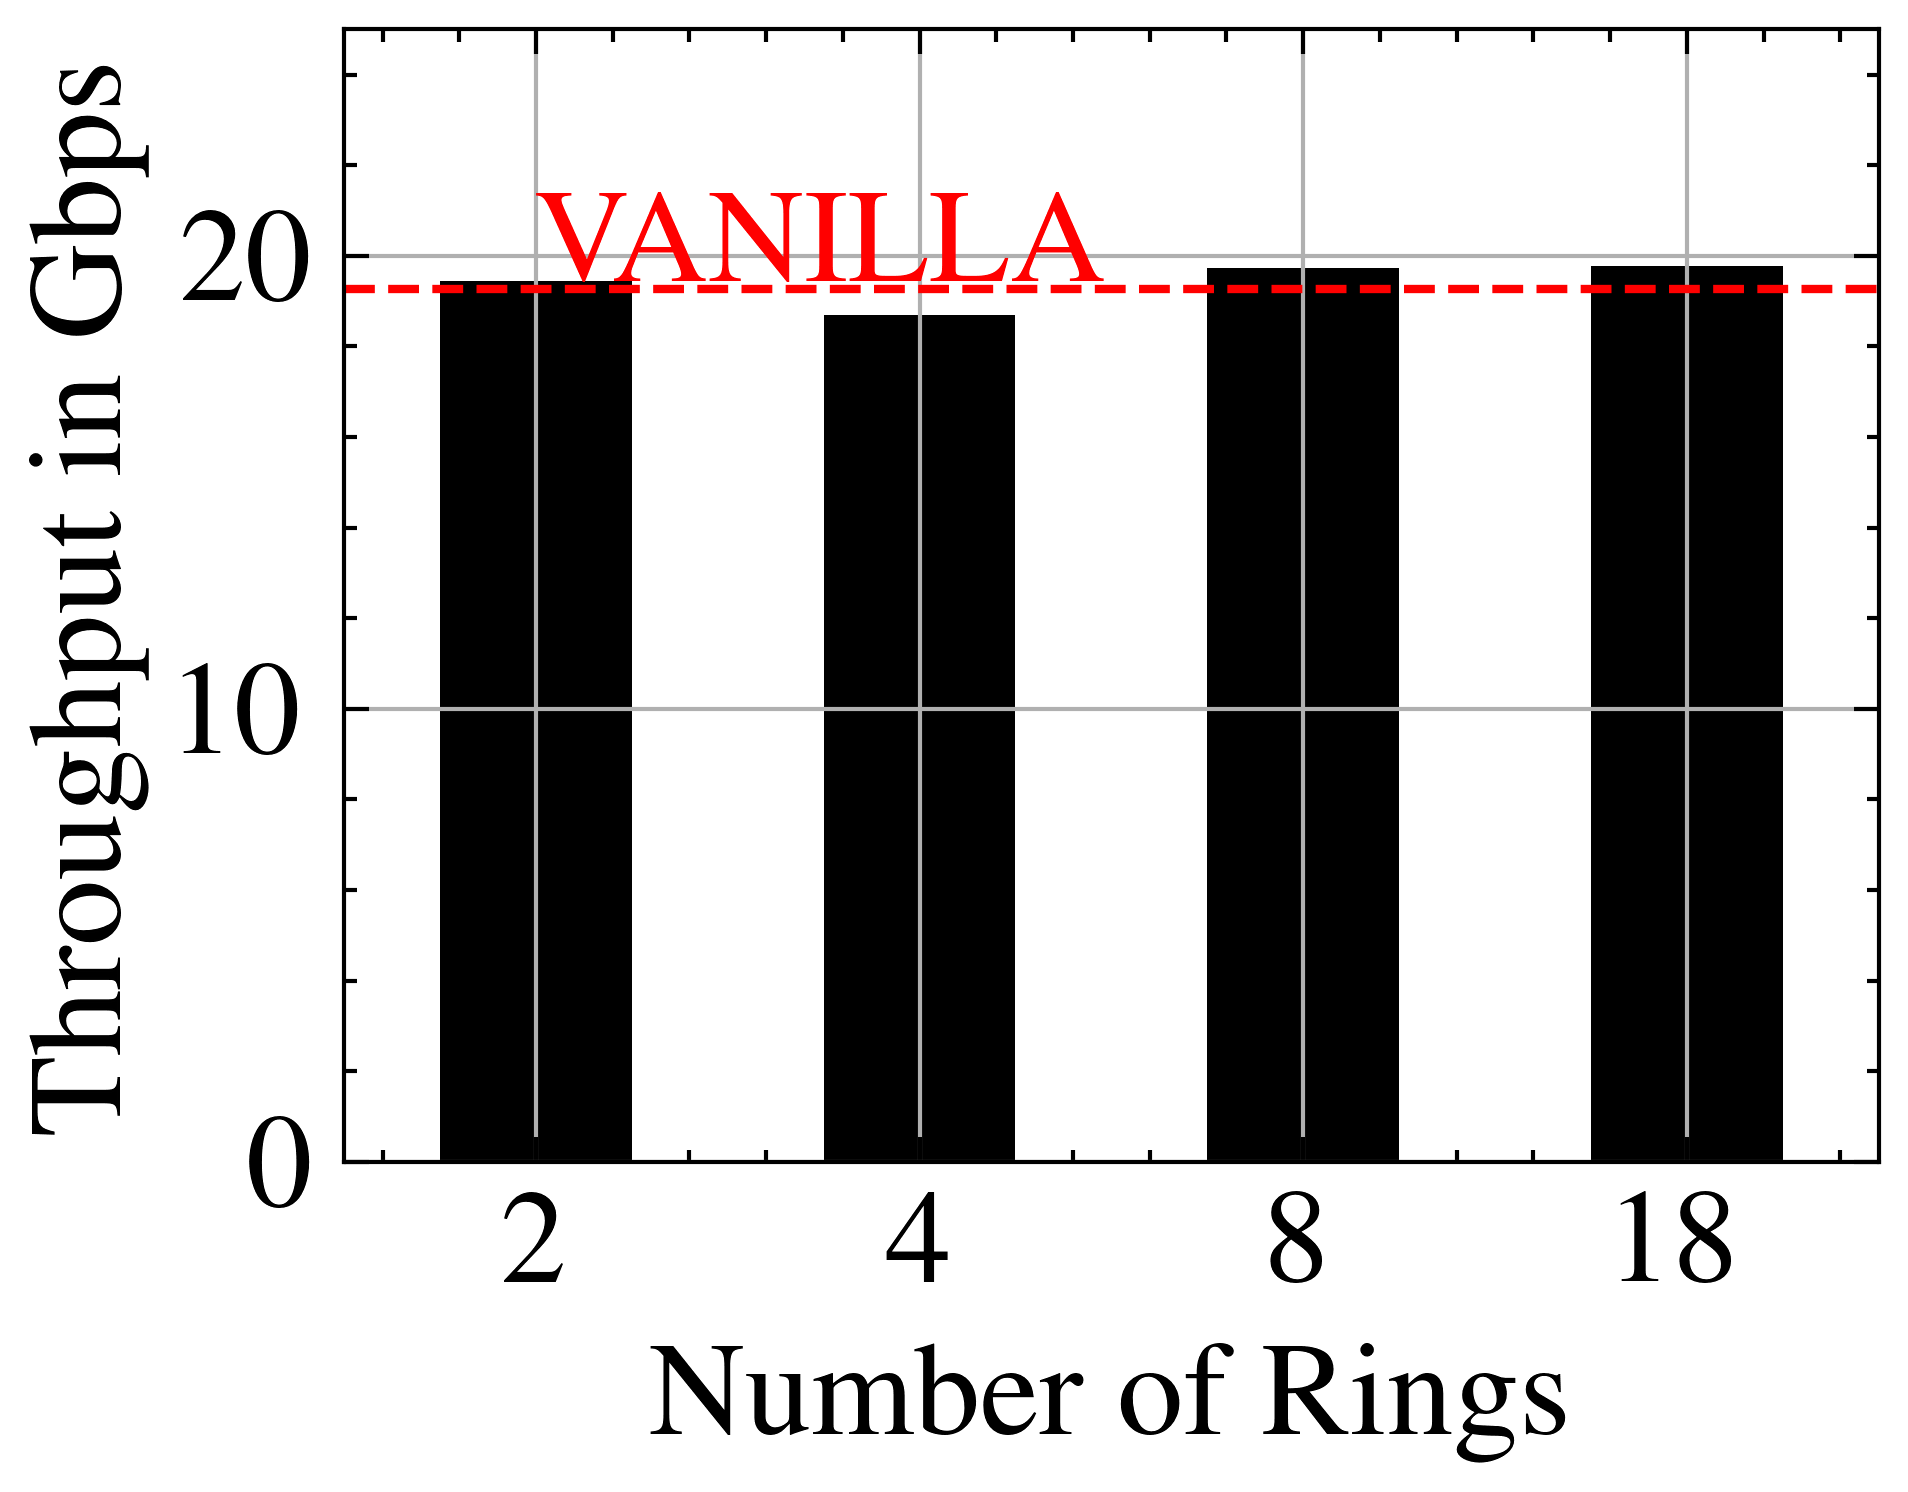

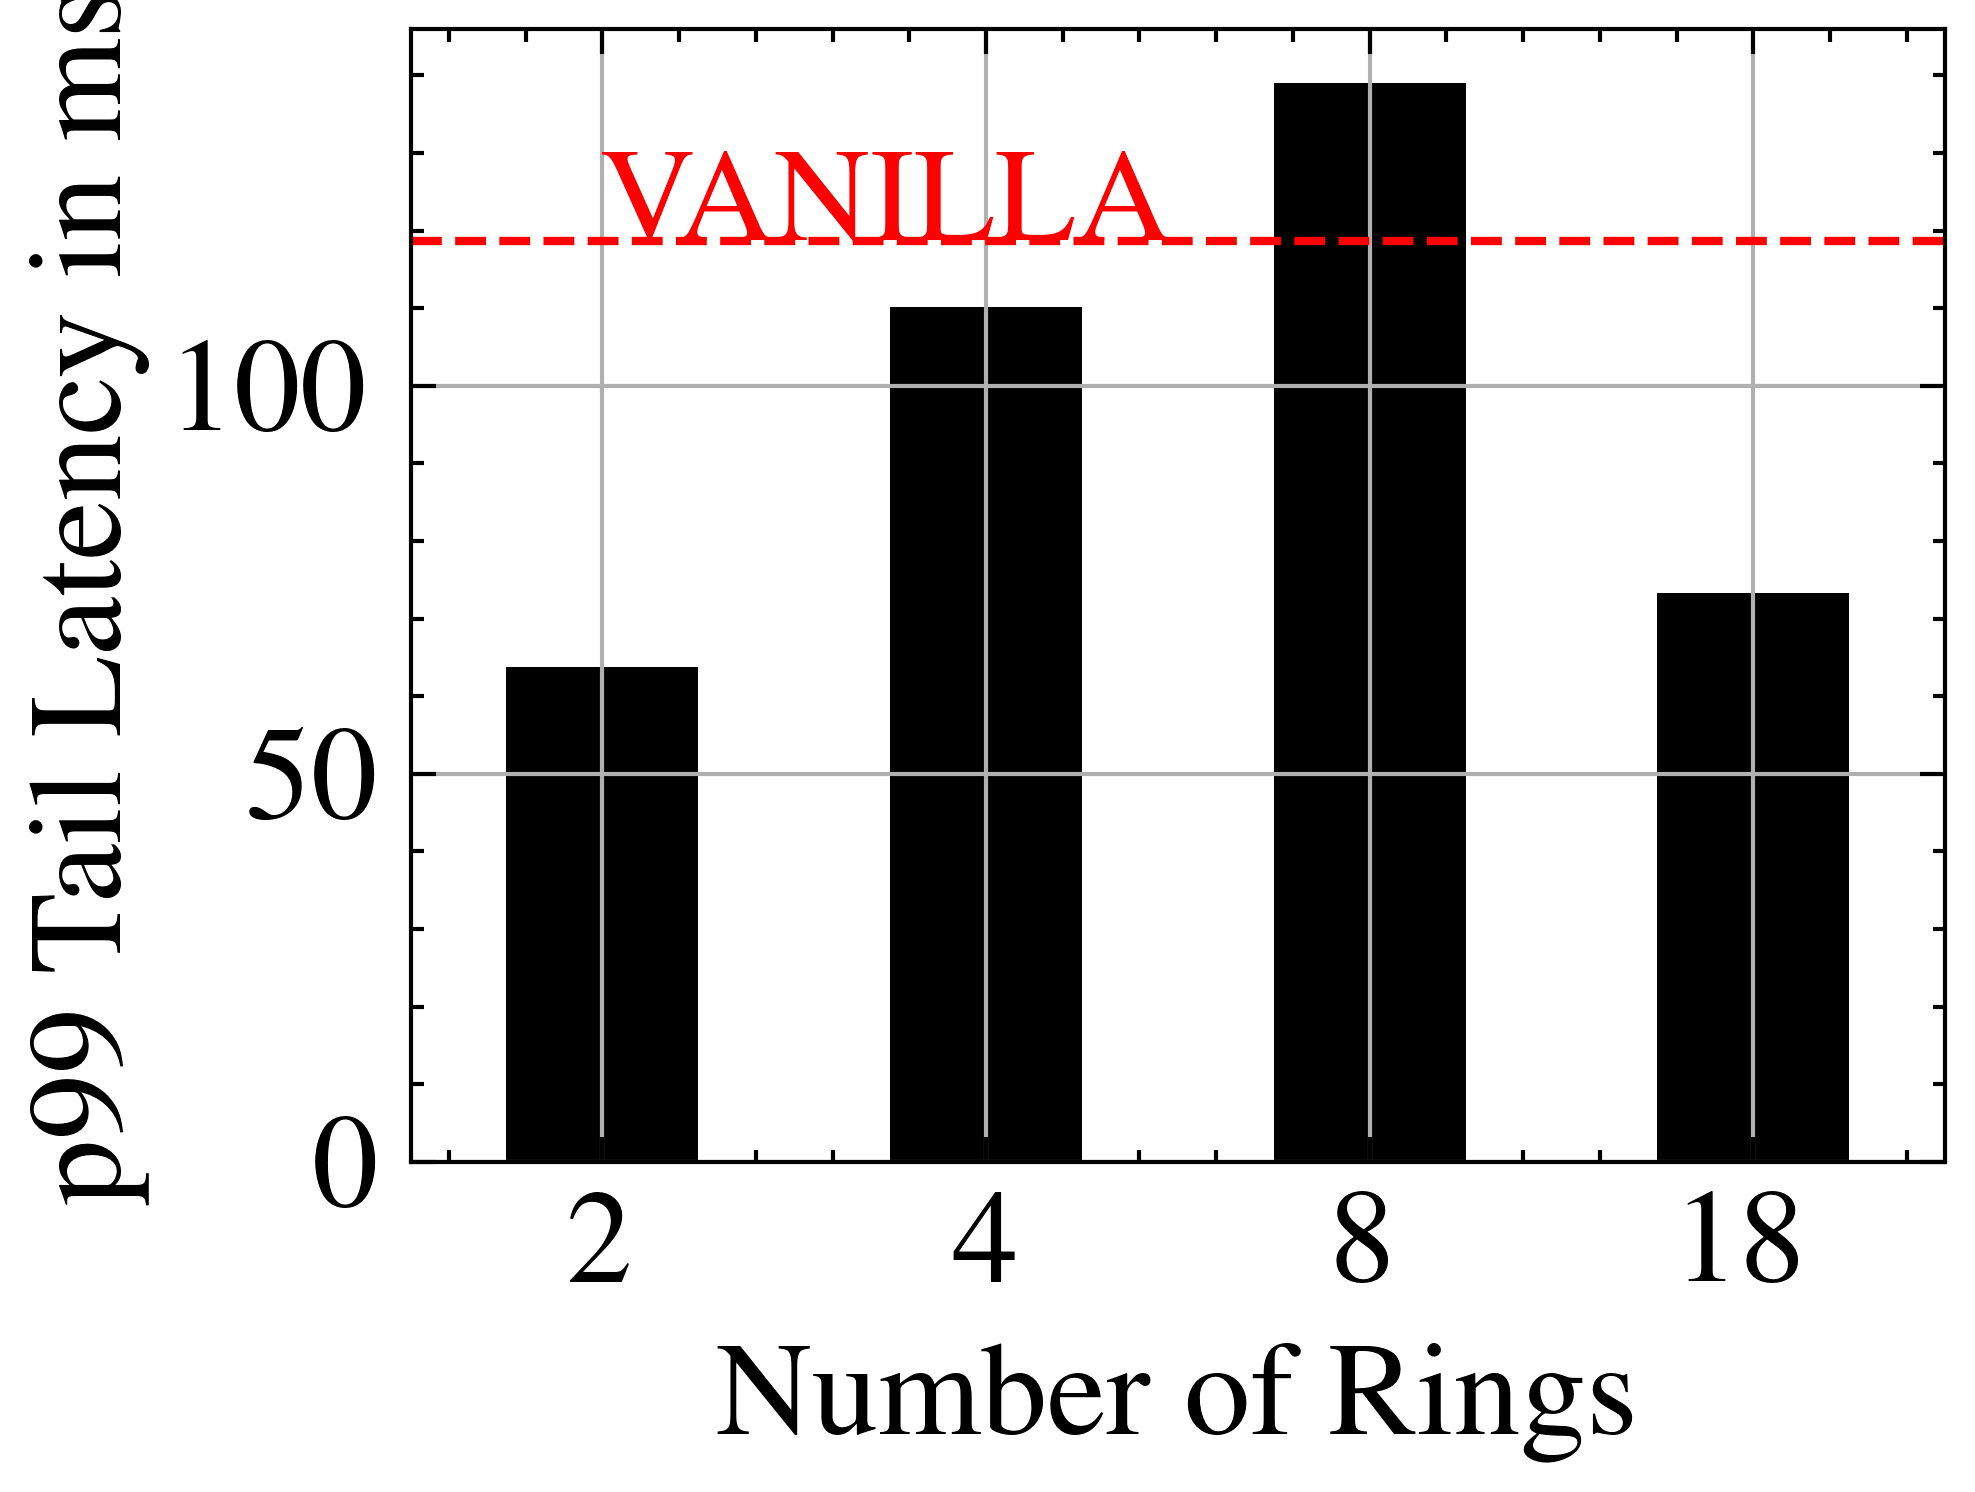

In [362]:
normal_value = df_vanilla.iloc[0].spinlock
text_offset = 0
text_spacing = .2
x = 'ring'
y = 'spinlock'
xlabel='Number of Rings'
ylabel='Spinlock CPU Usage'


plot_(df_mrb, x, y, xlabel, ylabel,
     ylim=ylim,
     normal_value=normal_value,
     text_spacing=text_spacing
)

plot_(df_mrb, x, 'throughput', xlabel, "Throughput in Gbps",
     ylim=[0, 25],
     normal_value=df_vanilla.iloc[0].throughput,
     text_spacing=text_spacing,
#      savefig='ssrb-bc-tp.pdf'
)

plot_(df_mrb, x, 'latency', xlabel, "p99 Tail Latency in ms",
     ylim=None,
     normal_value=df_vanilla.iloc[0].latency,
     text_spacing=text_spacing,
#      savefig='ssrb-bc-tp.pdf'
)

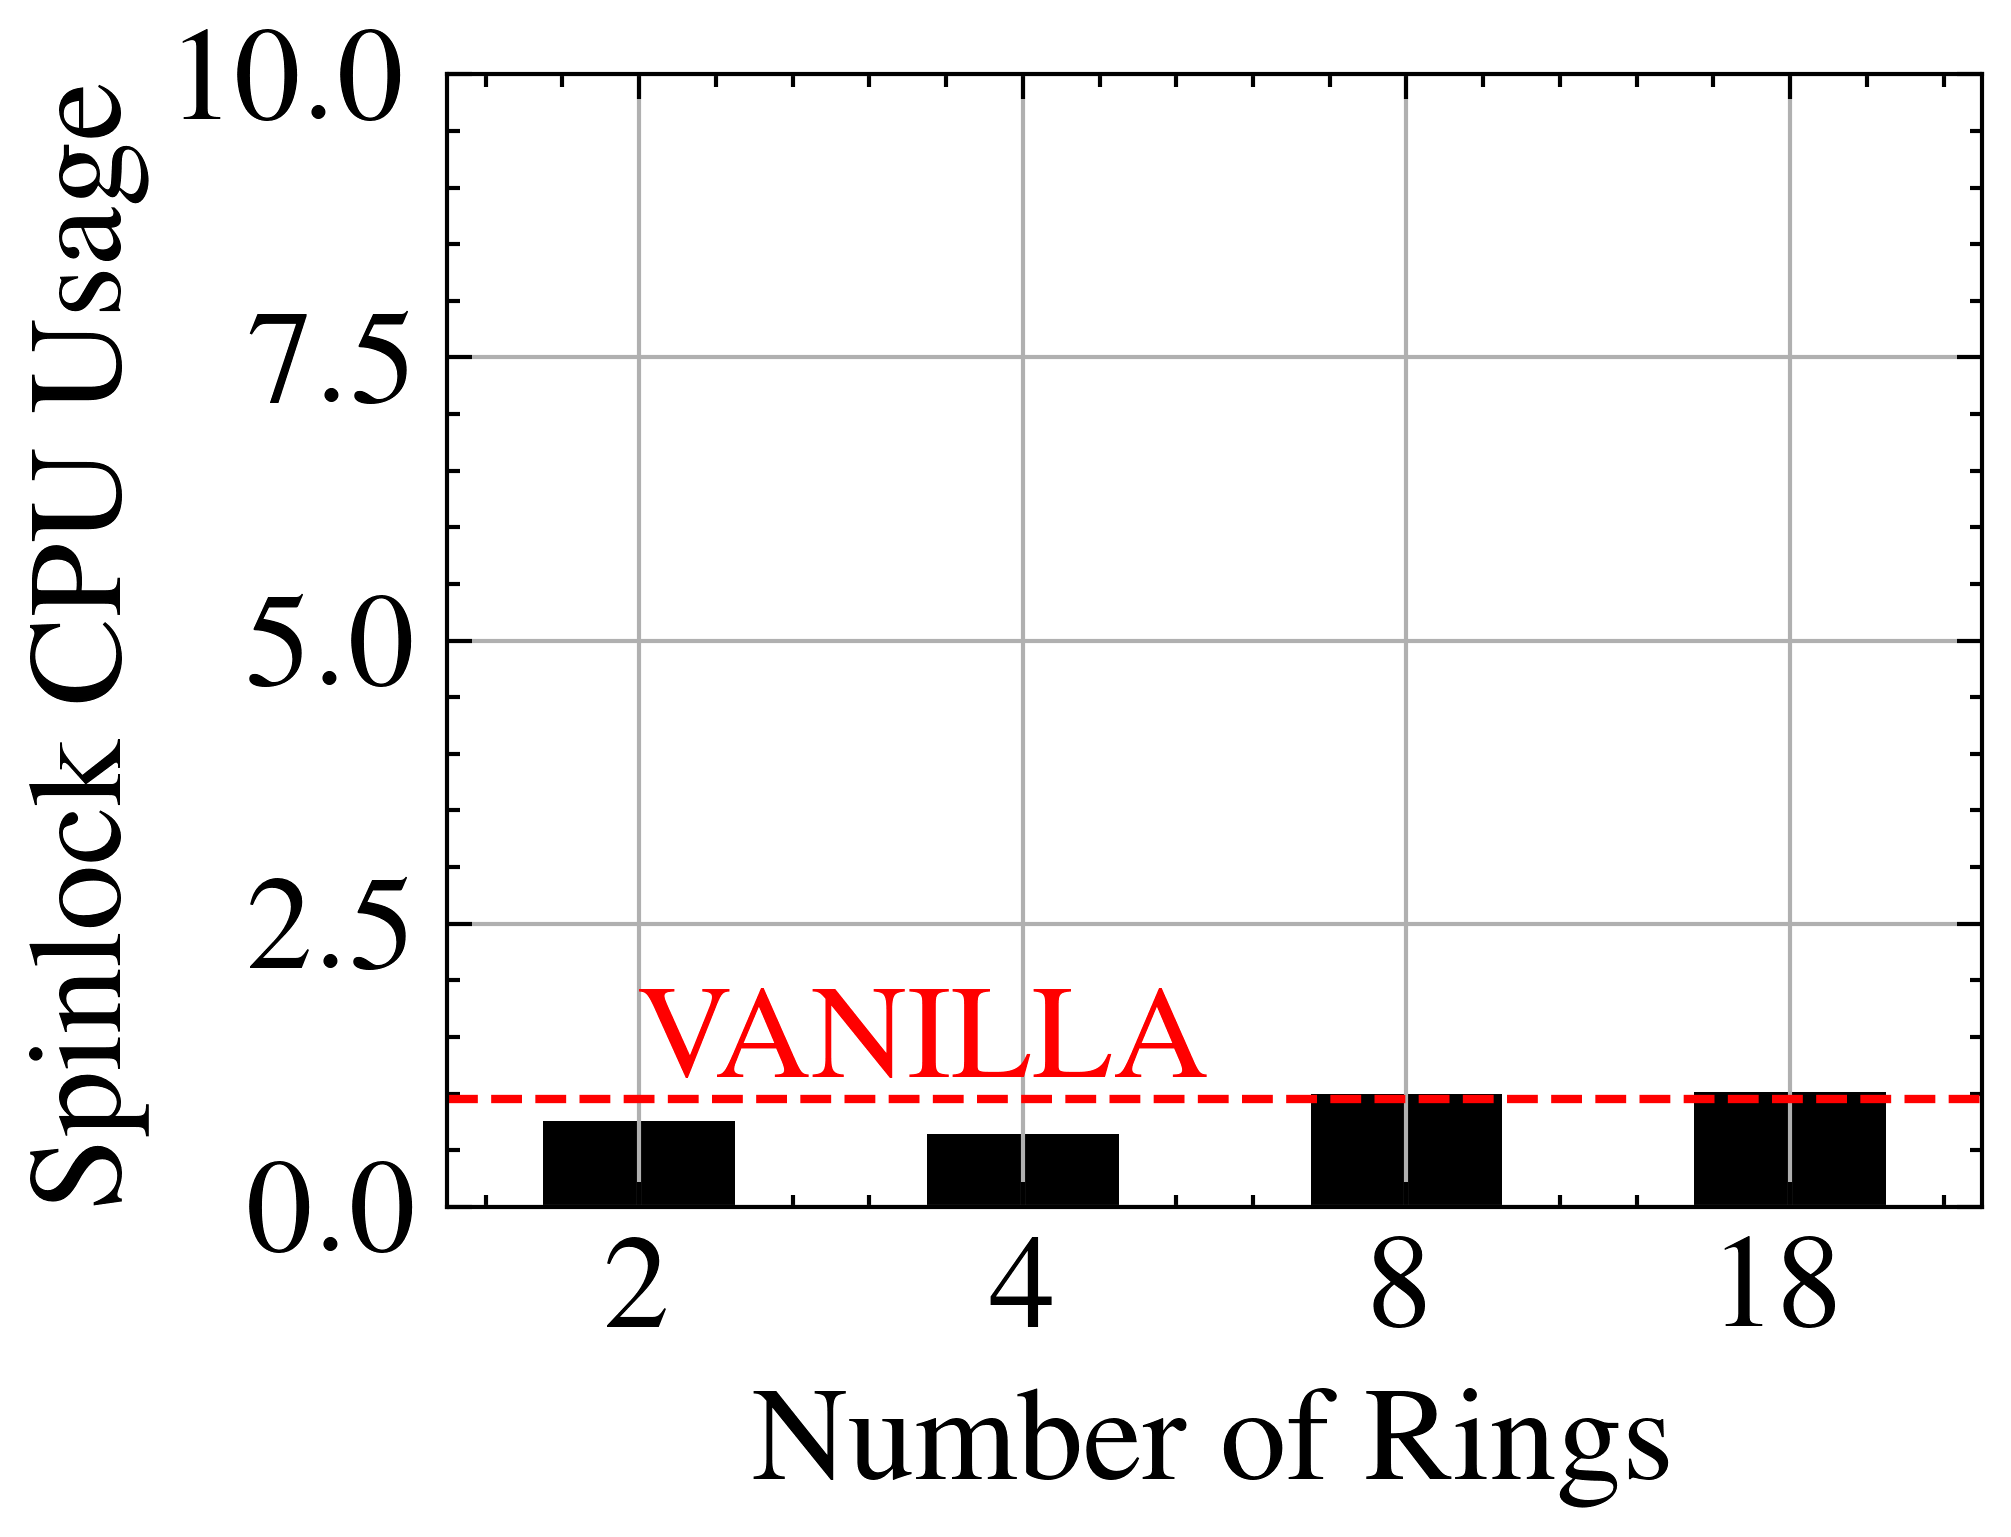

In [363]:
normal_value = df_vanilla.iloc[0].spinlock
text_offset = 0
text_spacing = .2
x = 'ring'
y = 'spinlock'
xlabel='Number of Rings'
ylabel='Spinlock CPU Usage'


plot_(df_mrb_str, x, y, xlabel, ylabel,
     ylim=ylim,
     normal_value=normal_value,
     text_spacing=text_spacing
)

In [364]:
best_batch = df_batch[df_batch.batch == 2]
best_mrb = df_mrb_str[df_mrb_str.ring == 2]

df = pd.concat([df_vanilla, df_nq, best_batch, best_mrb])

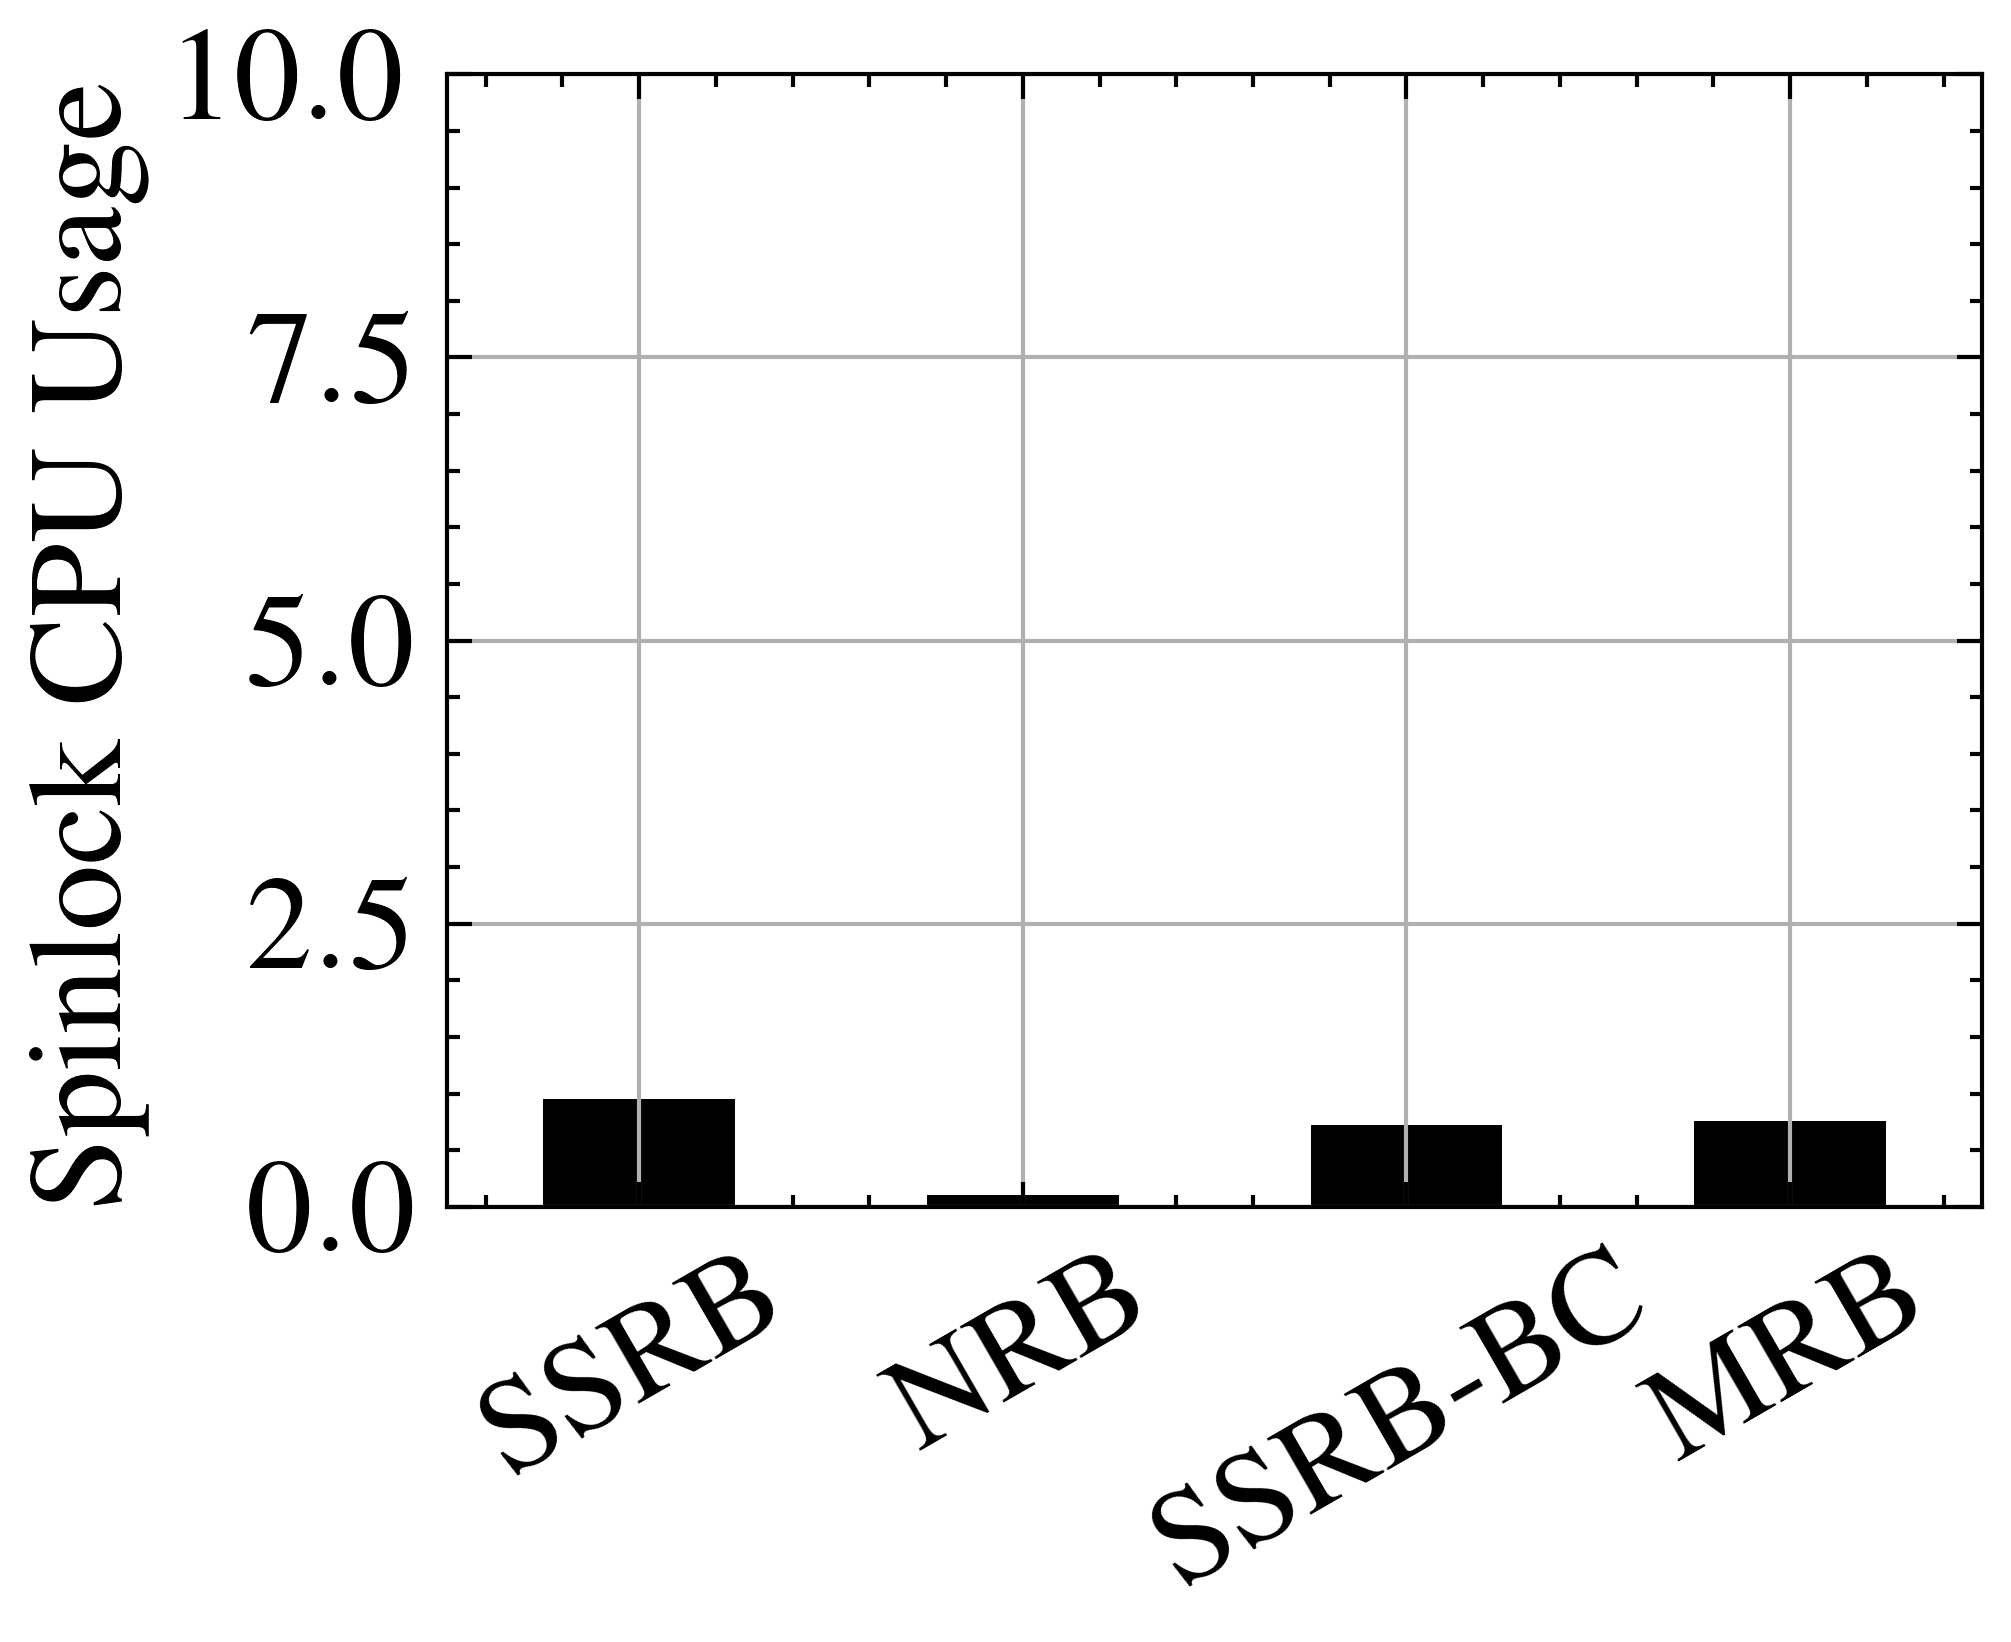

In [365]:
with plt.style.context(['science', 'ieee']):
    update_fontsize(16)
    df.plot.bar(x='variant', y=y, legend=None, grid=True,
               xlabel='', ylabel=ylabel, ylim=ylim)
    plt.xticks(rotation=30)
    plt.show()

In [366]:
df_batch.columns

Index(['throughput', 'latency', 'cpu', 'num_pids', 'decrypt_worker',
       'decrypt_packet', 'spinlock', 'cache_miss', 'cache_ops',
       'context_switch', 'migrations', 'faults', 'l1_miss', 'l1_ops',
       'llc_miss', 'llc_ops', 'start', 'end', 'batch', 'duration',
       'cache_miss_ratio', 'l1_ratio', 'llc_ratio', 'migrations/s', 'cs/s',
       'faults/s', 'variant'],
      dtype='object')

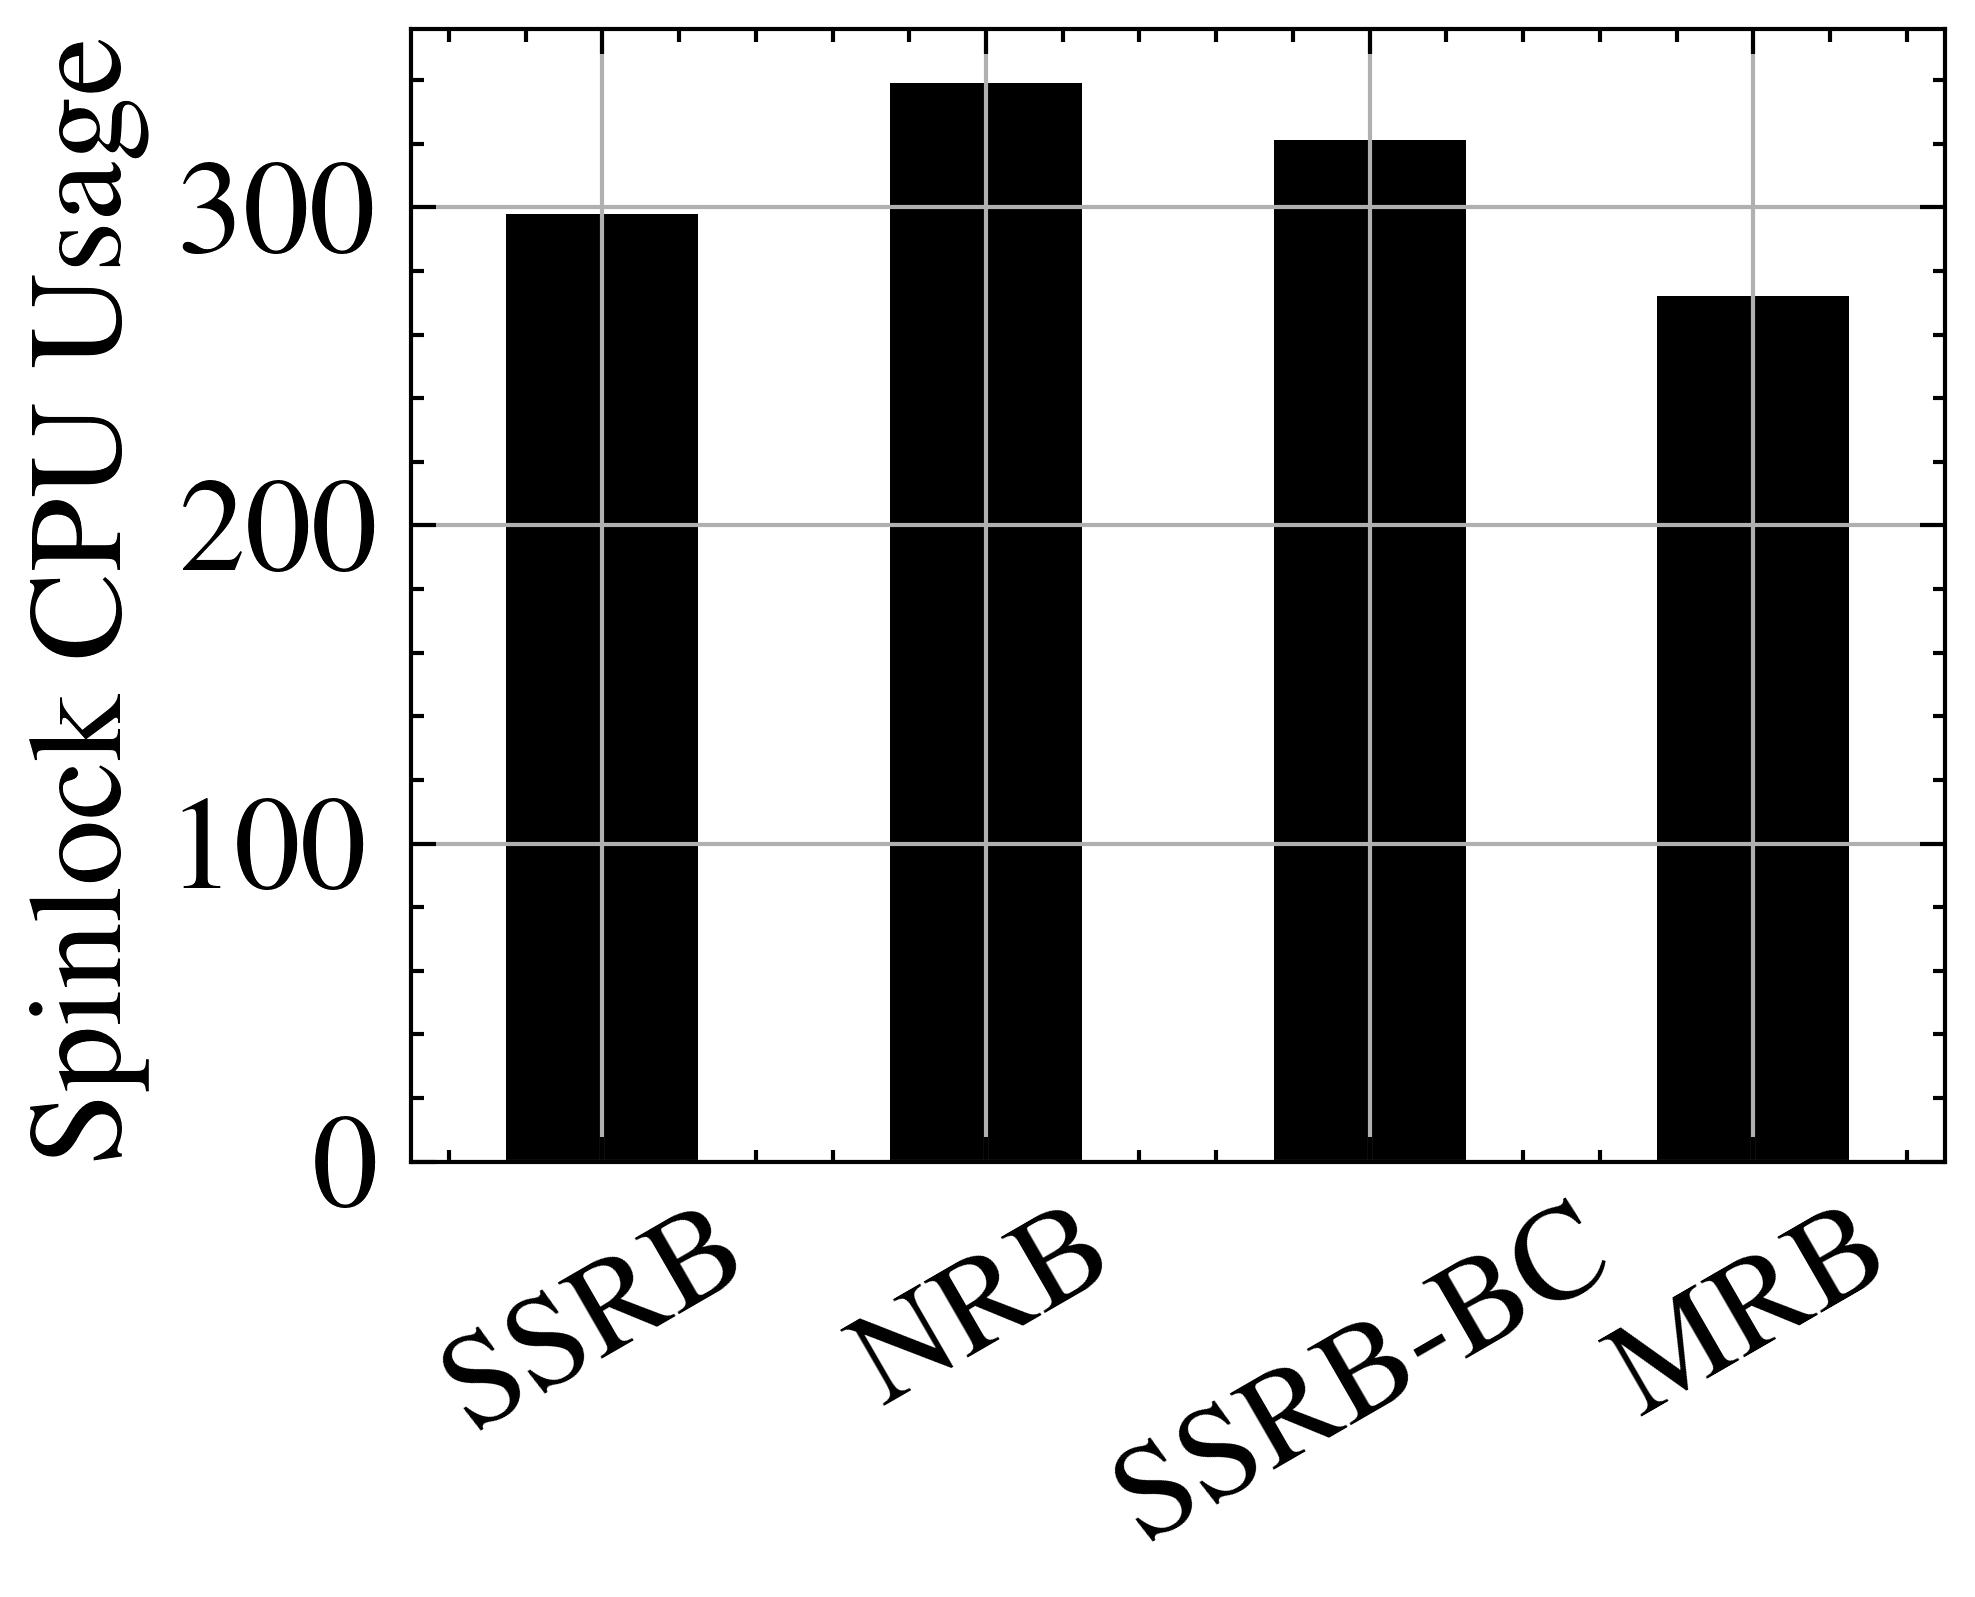

In [367]:
y = "num_pids"

with plt.style.context(['science', 'ieee']):
    update_fontsize(16)
    df.plot.bar(x='variant', y=y, legend=None, grid=True,
               xlabel='', ylabel=ylabel, ylim=None)
    plt.xticks(rotation=30)
    plt.show()